# Matrix Profile Example
## 2018 NYC Yellow Taxi Passengers

In this example, we use the MPX algorithm to perform both data mining and exploratory analysis tasks. MPX is an exact algorithm; meaning that it will not give an approximate solution. The data set is composed of aggregated passenger counts for yellow taxi cabs in NYC during the year 2018. If you are interested in learning more about the original data, please refer to the "NYC Taxi 2018 Aggregation" notebook.

Note that MPX is the default "compute" algorithm for exact computation.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import matrixprofile as mp

%matplotlib inline

# Load Data

Here we load in the aggregated data and make sure that the datetime is the correct data type and set as the index.

In [11]:
df = pd.read_csv('data/WDC_ADG.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').sort_index()

# Data Sample and Descriptive Stats

In [12]:
df.head()

,Average Digested Growth
Date,
1986-08-01,1.000000
1986-09-01,1.833333
1986-10-01,2.666667
1986-11-01,3.500000
1986-12-01,4.333333


Here we see a minimum passenger count of 3. Interesting...

In [14]:
df['Average Digested Growth'].describe()

count    418.000000
mean      16.795455
std       21.342230
min      -19.500000
25%       -0.791667
50%       11.666667
75%       33.041667
max       55.833333
Name: Average Digested Growth, dtype: float64

# Visualize Raw Data

Visualizing the raw data shows that you can see some trends around certain periods. However, imagine if the plot was smaller or there were many more data points. It would become very cumbersome to perform this analysis manually.

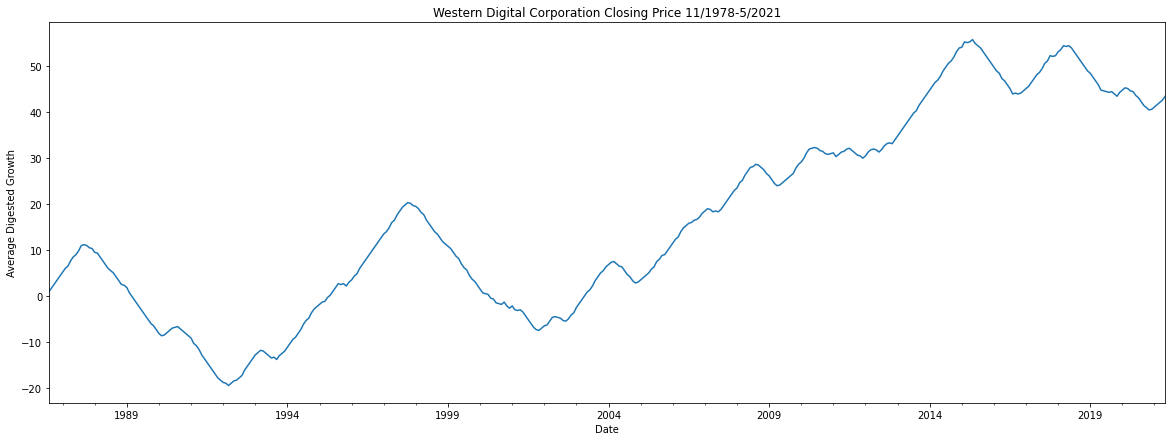

In [15]:
df.plot(figsize=(20,7), legend=None, title='Western Digital Corporation Closing Price 11/1978-5/2021')
plt.xlabel('Date')
plt.ylabel('Average Digested Growth')
plt.show()

# Compute Matrix Profiles

Here we compute Matrix Profiles over varying window sizes:

* 4 hours
* 8 hours
* 12 hours (Half of a day)
* 24 hours (A day)
* 168 hours (7 days)
* 720 hours (30 days)

In [26]:
windows = [
#     ('4 Hours', 4),
#     ('8 Hours', 8),
#     ('12 Hours', 12),
    ('24 Hours', 24),
#     ('3 Days', 3 * 24),
#     ('10 Days', 10 * 24),
#     ('20 Days', 20 * 24),
#     ('30 Days', 30 * 24),
]

profiles = {}

for label, window_size in windows:
    profile = mp.compute(df['Average Digested Growth'].values, window_size)
    key = '{} Profile'.format(label)
    profiles[key] = profile

# Plot Matrix Profiles

Below is a plot showing the different Matrix Profiles over the window sizes described above. Notice that the window size chosen drastically changes the Matrix Profile that is computed. When analyzing your data, it is important to choose appropriate window sizes to answer your desired questions.

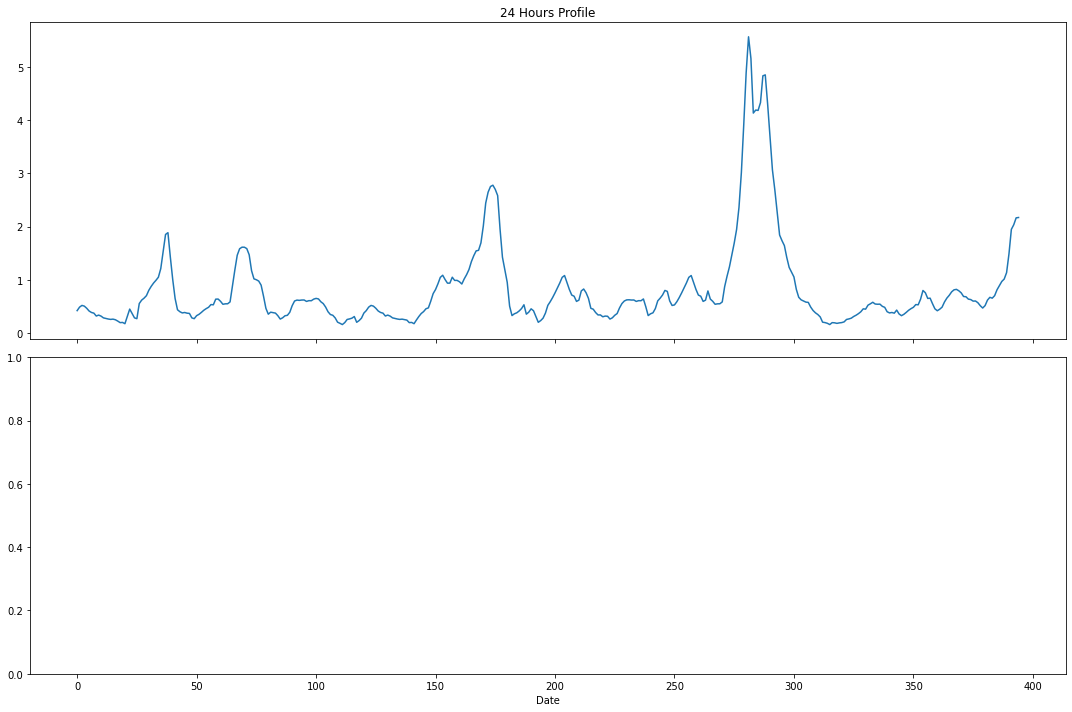

In [40]:
#Plot the signal data
fig, axes = plt.subplots(2,1,sharex=True,figsize=(15,10))

for ax_idx, window in enumerate(windows):
    key = '{} Profile'.format(window[0])
    profile = profiles[key]
    axes[ax_idx].plot(profile['mp'])
    axes[ax_idx].set_title(key)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Find Discords

Here we find the top 5 anomalies for each window. An exclusion zone is required to avoid matching on time periods that are very close to one another.

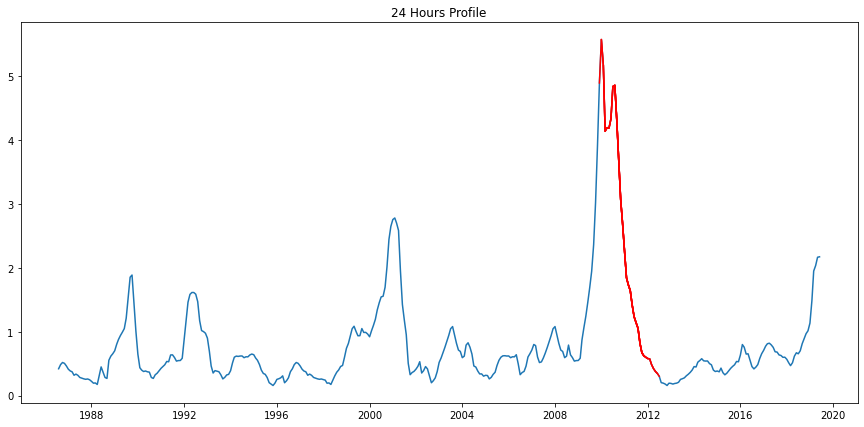

In [41]:
for label, window_size in windows:
    key = '{} Profile'.format(label)
    profiles[key] = mp.discover.discords(profiles[key], k=5)
    
    window_size = profiles[key]['w']
    mp_adjusted = np.append(profiles[key]['mp'], np.zeros(window_size - 1) + np.nan)
    
    plt.figure(figsize=(15, 7))
    ax = plt.plot(df.index.values, mp_adjusted)
    plt.title(key)
    
    for start_index in profiles[key]['discords']:
        x = df.index.values[start_index:start_index+window_size]
        y = mp_adjusted[start_index:start_index+window_size]
        plt.plot(x, y, c='r')
    
    plt.show()

# 24 Hour Discords

Here we do a little bit of Googling to figure out why these are potential top discords.

In [42]:
key = '24 Hours Profile'
profile = profiles[key]
window_size = profile['w']
mp_adjusted = np.append(profile['mp'], np.zeros(window_size - 1) + np.nan)
df['24 Hours Profile'] = mp_adjusted

Date
2010-01-01    5.569969
2010-02-01    5.162371
2010-03-01    4.135239
2010-04-01    4.191987
2010-05-01    4.185183
2010-06-01    4.332351
2010-07-01    4.835533
2010-08-01    4.853684
2010-09-01    4.299634
2010-10-01    3.687588
2010-11-01    3.066465
2010-12-01    2.691642
2011-01-01    2.257213
2011-02-01    1.841635
2011-03-01    1.735513
2011-04-01    1.642913
2011-05-01    1.419612
2011-06-01    1.232606
2011-07-01    1.142560
2011-08-01    1.053450
2011-09-01    0.819611
2011-10-01    0.670917
2011-11-01    0.622778
2011-12-01    0.600118
Name: 24 Hours Profile, dtype: float64
Date
2010-02-01    5.162371
2010-03-01    4.135239
2010-04-01    4.191987
2010-05-01    4.185183
2010-06-01    4.332351
2010-07-01    4.835533
2010-08-01    4.853684
2010-09-01    4.299634
2010-10-01    3.687588
2010-11-01    3.066465
2010-12-01    2.691642
2011-01-01    2.257213
2011-02-01    1.841635
2011-03-01    1.735513
2011-04-01    1.642913
2011-05-01    1.419612
2011-06-01    1.232606
2011-07-

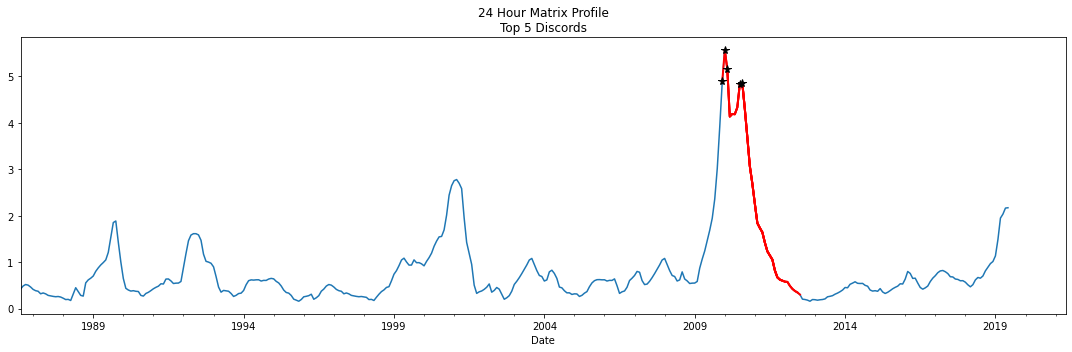

In [43]:
ax = df[key].plot(title='24 Hour Matrix Profile\nTop 5 Discords', figsize=(15,5))

for discord in profile['discords']:
    df.iloc[discord:discord+window_size][key].plot(ax=ax, c='r', lw='2')
    print(df.iloc[discord:discord+window_size][key])

df.iloc[profile['discords']][key].plot(kind='line', marker='*', c='black', markersize=8, ax=ax, lw=0)
# plt.text('01-04-2018', 1.75, 'New Years', c='black')
# plt.text('02-07-2018', 1.65, '???', c='black')
# plt.text('03-14-2018', 2.675, 'Daylight Savings Begin', c='black')
# plt.text('9-24-2018', 2.25, 'Daylight Savings End', c='black')
# plt.text('11-18-2018', 3.1, 'Snow Storm', c='black')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# 7 Day Discords

Here we do a little bit of Googling to figure out why these are potential top discords.

In [44]:
key = '7 Days Profile'
profile = profiles[key]
window_size = profile['w']
mp_adjusted = np.append(profile['mp'], np.zeros(window_size - 1) + np.nan)
df[key] = mp_adjusted

KeyError: '7 Days Profile'

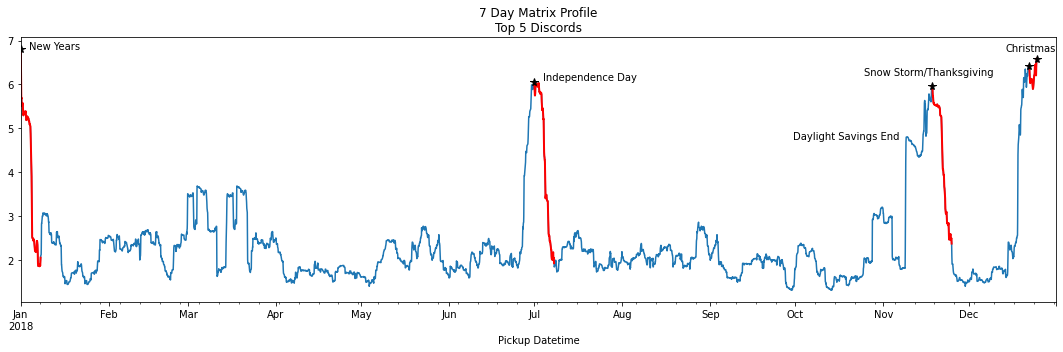

In [44]:
ax = df[key].plot(title='7 Day Matrix Profile\nTop 5 Discords', figsize=(15,5))

for discord in profile['discords']:
    df.iloc[discord:discord+window_size][key].plot(ax=ax, c='r', lw='2')

df.iloc[profile['discords']][key].plot(kind='line', marker='*', c='black', markersize=8, ax=ax, lw=0)
plt.text('01-04-2018', 6.8, 'New Years', c='black')
plt.text('07-04-2018', 6.1, 'Independence Day', c='black')
plt.text('9-30-2018', 4.75, 'Daylight Savings End', c='black')
plt.text('10-25-2018', 6.2, 'Snow Storm/Thanksgiving', c='black')
plt.text('12-14-2018', 6.75, 'Christmas', c='black')
plt.xlabel('Pickup Datetime')
plt.tight_layout()
plt.show()